In [1]:
import pandas as pd
import numpy as np
from numpy import random

import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

import tree
import simulation as sim
import sim_utils as sut
import count_model as cmod
import tree_utils as tu

In [3]:
from comparison_functions import *

In [4]:
rseed = 42
np.random.seed(rseed)

In [5]:
real_name = "velten"
real_cells = pd.read_csv("/home/npapado/Documents/data/steinmetz/all_cells.txt",
                         sep=" ", header=0, index_col=0)
real_genes = pd.read_csv("/home/npapado/Documents/data/steinmetz/all_genes.txt",
                         sep=" ", header=0, index_col=0)

real_stats = [real_cells, real_genes]

(naively) fit cell scalings

In [6]:
real_scalings = np.log(real_cells.loc["total"] / np.mean(real_cells.loc["total"]))
scale_mean = np.mean(real_scalings)
scale_var = np.sqrt(np.var(real_scalings))

In [7]:
top = [[0,1], [0,2], [0,3], [0,4], [0,5]]

branches = np.unique(np.array(top).flatten())
time = {b: 50 for b in branches}
G = real_genes.shape[1]
t = tree.Tree(topology=top, G=G, time=time, num_branches=len(branches), branch_points=1, modules=30)

uMs, Ws, Hs = sim.simulate_lineage(t, intra_branch_tol=-1, inter_branch_tol=0)

/home/npapado/Documents/repos/prosstt/dev/simulation.py:154: UserWarning: No argument 'a' specified in kwargs: using gamma and a=0.04
  "No argument 'a' specified in kwargs: using gamma and a=0.04", UserWarning)
/home/npapado/miniconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [28]:
rel_expr = np.array([uMs[b] for b in t.branches])
avg_relative_expr = np.exp(np.mean(np.mean(rel_expr, axis=0), axis=0))
proposed_means = real_genes.loc['means']
avg_relative_expr[avg_relative_expr < np.min(proposed_means)] = np.min(proposed_means)
t.add_genes(uMs, np.array(proposed_means) / avg_relative_expr)

In [29]:
scale_mean, scale_var

(-0.127806977638942, 0.49310118495619082)

In [67]:
alpha_mean = np.log(10)
alpha_var = np.log(1.5)
beta_mean = np.log(10)
beta_var = np.log(1.5)

alpha = np.exp(random.normal(loc=alpha_mean, scale=alpha_var, size=t.G))
beta = np.exp(random.normal(loc=beta_mean, scale=beta_var, size=t.G)) + 1
X, labs, brns, scalings = sim.sample_density(t, 1035, alpha=alpha, beta=beta,
                                             scale=True, scale_mean=scale_mean, scale_v=scale_var)

sim_means = np.mean(X, axis=0)
sim_vars = np.var(X, axis=0)
sim_zeros_gene = np.sum(X==0, axis=0)
sim_zeros_cell = np.sum(X==0, axis=1)
sim_totals = np.sum(X, axis=1)

sim_means[sim_means<=0] = 1e-4
sim_vars[sim_vars<=0] = 1e-4

simulated = [sim_means, sim_vars, sim_zeros_gene, sim_zeros_cell, sim_totals]

In [68]:
np.mean(np.log2(sim_totals)), np.mean(np.log2(real_cells.loc['total']))

(18.468427022847795, 18.706370190224089)

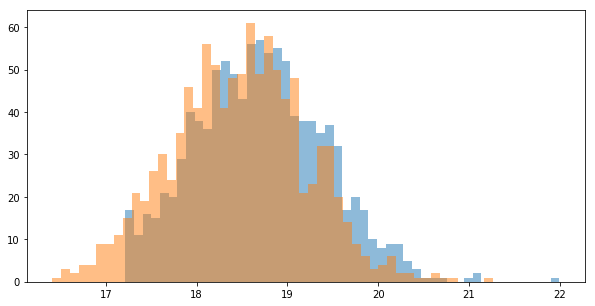

In [69]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
h1=ax.hist(np.log2(real_cells.loc['total']), label=real_name, bins=50, alpha=0.5)
h2=ax.hist(np.log2(sim_totals), label="simulated", bins=50, alpha=0.5)

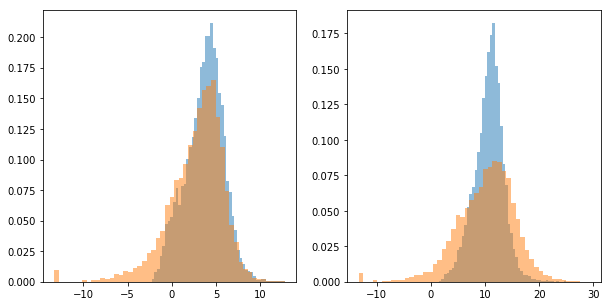

In [70]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(10, 5)
h1=ax[0].hist(np.log2(real_genes.loc['means']), label=real_name, bins=50, alpha=0.5, density=True)
h2=ax[0].hist(np.log2(sim_means), label="simulated", bins=50, alpha=0.5, density=True)
h1=ax[1].hist(np.log2(real_genes.loc['var']), label=real_name, bins=50, alpha=0.5, density=True)
h2=ax[1].hist(np.log2(sim_vars), label="simulated", bins=50, alpha=0.5, density=True)

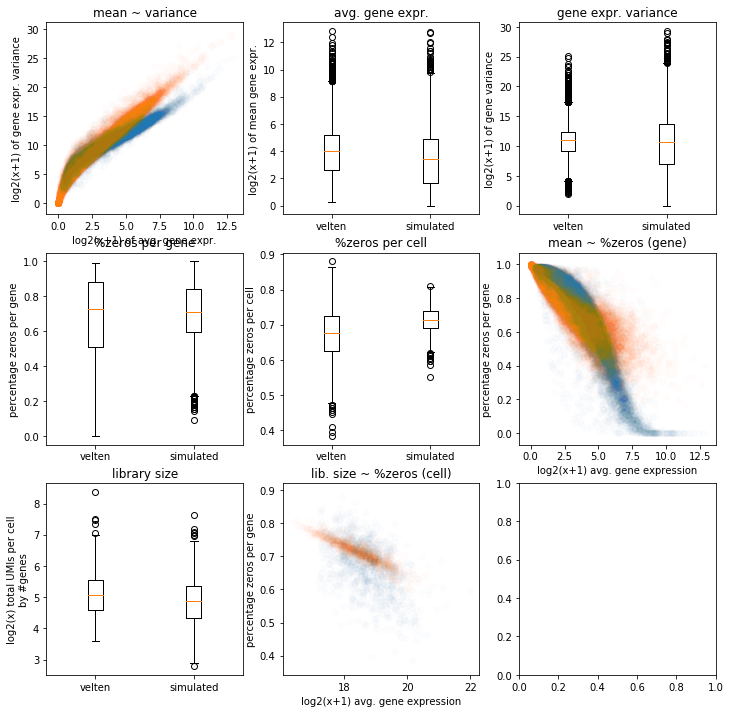

In [84]:
plot(real_name, real_stats, simulated, alpha=0.01)